TL;DR: our cosmology slightly differs from astropy, ...somehow.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import copy
from matplotlib.colors import CenteredNorm

from astropy.cosmology import FlatLambdaCDM as FlatLambdaCDM_AP
import lenstronomy
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util

from math import pi

import functorch
import matplotlib.pyplot as plt
import torch

from caustic.constants import arcsec_to_rad, rad_to_arcsec
from caustic.cosmology import FlatLambdaCDM
from caustic.lenses import NFW, Point, SIS, SIE, MultiplaneLens
from caustic.sources import Sersic
from caustic.utils import get_meshgrid


s_to_day = 1 / (24 * 60 * 60)

In [3]:
def setup_grids(res=0.05, n_pix=100):
    # Caustic setup
    thx, thy = get_meshgrid(res, n_pix, n_pix)

    # Lenstronomy setup
    fov = res * n_pix
    ra_at_xy_0, dec_at_xy_0 = ((-fov + res) / 2, (-fov + res) / 2)
    transform_pix2angle = np.array([[1, 0], [0, 1]]) * res
    kwargs_pixel = {
        "nx": n_pix,
        "ny": n_pix,  # number of pixels per axis
        "ra_at_xy_0": ra_at_xy_0,
        "dec_at_xy_0": dec_at_xy_0,
        "transform_pix2angle": transform_pix2angle,
    }
    pixel_grid = PixelGrid(**kwargs_pixel)
    thx_ls, thy_ls = pixel_grid.coordinate_grid(n_pix, n_pix)
    return thx, thy, thx_ls, thy_ls

In [4]:
thx, thy, thx_ls, thy_ls = setup_grids()

In [5]:
z_s = torch.tensor(1.2)
x = torch.tensor([0.5, 0.912, -0.442, 0.7, pi / 3, 1.4])

# Models
cosmology = FlatLambdaCDM("cosmo")
lens = SIE("sie", cosmology)
lens_model_list = ["SIE"]

cosmology_ls = FlatLambdaCDM_AP(cosmology.h0.value, cosmology.Om0.value, Tcmb0=0)
lens_ls = LensModel(
    lens_model_list=lens_model_list, z_lens=x[0].item(), z_source=z_s.item()
)

e1, e2 = param_util.phi_q2_ellipticity(phi=x[4].item(), q=x[3].item())
kwargs_ls = [
    {
        "theta_E": x[5].item(),
        "e1": e1,
        "e2": e2,
        "center_x": x[1].item(),
        "center_y": x[2].item(),
    }
]

In [6]:
from caustic.constants import c_Mpc_s, arcsec_to_rad
import lenstronomy.Util.constants as const

Text(0.5, 0.98, 'Time delay')

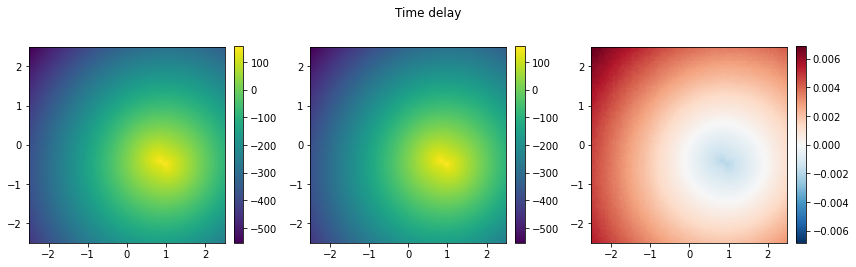

In [11]:
td = lens.time_delay(thx, thy, z_s, lens.x_to_dict(x))
td -= lens.time_delay(torch.tensor(0.0), torch.tensor(0.0), z_s, lens.x_to_dict(x))
td *= s_to_day

td_ls = lens_ls.arrival_time(thx_ls, thy_ls, kwargs_ls)
td_ls -= lens_ls.arrival_time(0.0, 0.0, kwargs_ls)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, (arr, ax) in enumerate(zip([td, td_ls, (td.numpy() - td_ls)], axs)):
    cmap = "RdBu_r" if i == 2 else None
    norm = CenteredNorm() if i == 2 else None
    im = ax.imshow(
        arr, extent=(-2.5, 2.5, -2.5, 2.5), origin="lower", cmap=cmap, norm=norm
    )
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.tight_layout()
fig.suptitle("Time delay")

Text(0.5, 0.98, 'Fermat potential')

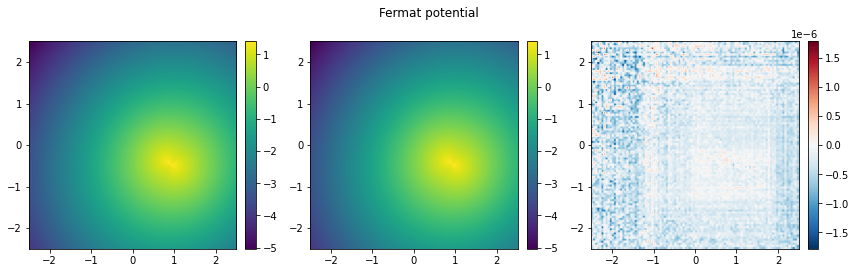

In [10]:
td = lens.fermat_potential(thx, thy, z_s, lens.x_to_dict(x))
td -= lens.fermat_potential(torch.tensor(0.0), torch.tensor(0.0), z_s, lens.x_to_dict(x))

td_ls = lens_ls.fermat_potential(thx_ls, thy_ls, kwargs_ls)
td_ls -= lens_ls.fermat_potential(0.0, 0.0, kwargs_ls)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, (arr, ax) in enumerate(zip([td, td_ls, (td.numpy() - td_ls)], axs)):
    cmap = "RdBu_r" if i == 2 else None
    norm = CenteredNorm() if i == 2 else None
    im = ax.imshow(
        arr, extent=(-2.5, 2.5, -2.5, 2.5), origin="lower", cmap=cmap, norm=norm
    )
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.tight_layout()
fig.suptitle("Fermat potential")

For reference

Text(0.5, 0.98, '$\\alpha_x$')

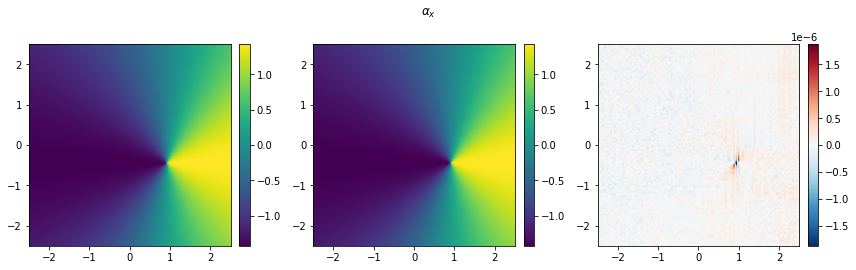

In [13]:
ax, _ = lens.alpha(thx, thy, z_s, lens.x_to_dict(x))
ax_ls, _ = lens_ls.alpha(thx_ls, thy_ls, kwargs_ls)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))


for i, (arr, ax) in enumerate(zip([ax, ax_ls, ax.numpy() - ax_ls], axs)):
    cmap = "RdBu_r" if i == 2 else None
    norm = CenteredNorm() if i == 2 else None
    im = ax.imshow(arr, extent=(-2.5, 2.5, -2.5, 2.5), origin="lower", cmap=cmap, norm=norm)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.tight_layout()
fig.suptitle(r"$\alpha_x$")

Text(0.5, 0.98, '$\\alpha_y$')

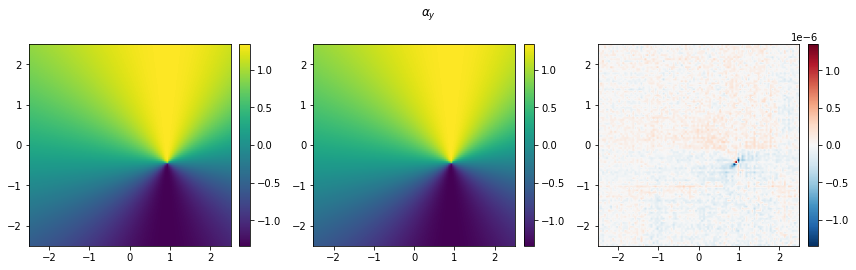

In [14]:
_, ay = lens.alpha(thx, thy, z_s, lens.x_to_dict(x))
_, ay_ls = lens_ls.alpha(thx_ls, thy_ls, kwargs_ls)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))


for i, (arr, ax) in enumerate(zip([ay, ay_ls, ay.numpy() - ay_ls], axs)):
    cmap = "RdBu_r" if i == 2 else None
    norm = CenteredNorm() if i == 2 else None
    im = ax.imshow(arr, extent=(-2.5, 2.5, -2.5, 2.5), origin="lower", cmap=cmap, norm=norm)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.tight_layout()
fig.suptitle(r"$\alpha_y$")

Text(0.5, 0.98, '$\\Psi$')

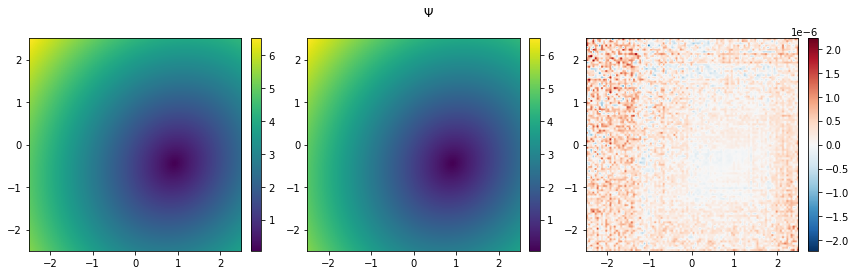

In [15]:
Psi = lens.Psi(thx, thy, z_s, lens.x_to_dict(x))
Psi_ls = lens_ls.potential(thx_ls, thy_ls, kwargs_ls)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))


for i, (arr, ax) in enumerate(zip([Psi, Psi_ls, Psi.numpy() - Psi_ls], axs)):
    cmap = "RdBu_r" if i == 2 else None
    norm = CenteredNorm() if i == 2 else None
    im = ax.imshow(arr, extent=(-2.5, 2.5, -2.5, 2.5), origin="lower", cmap=cmap, norm=norm)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.tight_layout()
fig.suptitle(r"$\Psi$")